# Header Material

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats as ss

from sklearn.gaussian_process import GaussianProcessRegressor,kernels
from sklearn.model_selection import train_test_split, KFold,LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [3]:
from src.models.constants import Constants
from src.models import util
from src.models.gaussian_process import featurize

In [4]:
plt.style.use('seaborn-v0_8-talk')
cmap = plt.get_cmap("tab10")
raw_dir = "D:/ukuru/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/raw"
processed_dir = "D:/ukuru/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/processed"
n_map = {1:"Base",2:"Thru Rnd 1",3:"Thru Rnd 2",4:"Thru Rnd 3",5:"Thru Rnd 4",6:"Thru Rnd 5",7:"Thru Rnd 6-GP"}
seed=0
df2 = pd.read_csv(processed_dir+"/"+"2-cleanedup_Round8-Standardized.csv")
print(df2.shape)
df2.head()

(140, 20)


,Unnamed: 0,Catalyst,Reaction,Tube,Date,Mass Catalyst,Mass Diluent,k_d,Y0,lifetime_yield,Y_pc,sqrtY0Y_pc,Pt,Sn,Ga,Fe,Cu,Ca,Mn,Zn
0,0,Pt1/γ-Al2O3 2/5/24,24-005,1,2024-02-05,20.0,120.2,0.011951,0.093141,7.793377,7.350753,0.827439,1,0.0,0.0,0.0,0.0,0.0,0,0
1,1,Pt1/γ-Al2O3 2/5/24,24-005,2,2024-02-05,20.1,120.0,0.011695,0.138308,11.826379,11.112063,1.239711,1,0.0,0.0,0.0,0.0,0.0,0,0
2,2,Pt1/γ-Al2O3 2/5/24,24-005,3,2024-02-05,20.0,120.0,0.010522,0.063163,6.002886,5.522449,0.590604,1,0.0,0.0,0.0,0.0,0.0,0,0
3,3,Pt1/γ-Al2O3 2/5/24,24-005,4,2024-02-05,20.0,120.0,0.009353,0.055320,5.915015,5.288208,0.540875,1,0.0,0.0,0.0,0.0,0.0,0,0
4,4,Pt1/γ-Al2O3 2/5/24,24-005,5,2024-02-05,20.1,120.2,0.009263,0.062064,6.700162,5.974731,0.608945,1,0.0,0.0,0.0,0.0,0.0,0,0


In [5]:
Sets = {"Training":["005","006","007","008","009","010","011","015","016"],
        "Round 1":["005","006","007","008","009","010","011","015","016","023"],
       "Round 2":["005","006","007","008","009","010","011","015","016","023","025"],
       "Round 3":["005","006","007","008","009","010","011","015","016","023","025","030"],
       "Round 4":["005","006","007","008","009","010","011","015","016","023","025","030","031"],
        "Round 5 GP":["005","006","007","008","009","010","011","015","016","023","025","030","031","034"],
        "Round 6 GP":["005","006","007","008","009","010","011","015","016","023","025","030","031","034","038"],
        "Round 5 KNN":["005","006","007","008","009","010","011","015","016","023","025","030","031","035"],
        "Round 6 KNN":["005","006","007","008","009","010","011","015","016","023","025","030","031","035","049"],
       "Coarse Grid":["005","006","007","008","009","010","011","015","016","023","025","030","031"],
        "Fine Grid":["005","006","007","008","009","010","011","015","016","023","025","030","031","034","035","038","049"],
        "Replicate Runs":["005","006","007","008","009","010","011","015","016","023","025","030","031","034","035","038","049","050","051","052","053","054","055","056","058","061"],
        "Final Round":["005","006","007","008","009","010","011","015","016","023","025","030","031","034","035","038","049","050","051","052","053","054","055","056","058","061","064"]}


In [6]:
def remove_duplicates(X_train,X_test,y_train,y_test,verbose=False,duplicate_if_different_tubes=True):
    idx_to_remove = []
    for i in range(X_test.shape[0]): #for each test datapoint:
        for j in range(X_train.shape[0]):
            if duplicate_if_different_tubes: #if same cat tested in diff tubes consider this a duplicate
                n=1
            else:
                n=0
                if np.array_equal(X_test[i,n:],X_train[j,n:]):
                    if verbose:
                        print("Found equal")
                        print(X_test[i,:])
                        print(X_train[j,:])
                    idx_to_remove.append(j)
    return np.delete(X_train,idx_to_remove,axis=0),np.delete(y_train,idx_to_remove,axis=0)

def is_duplicate(df,idx,idx_list):
    #returns True/False if catalyst with index idx has same metal composiition as any of the catalysts in idx_list
    metals = ['Sn','Ga','Fe','Cu','Ca']
    df = df.loc[:,metals] #just want metals  
    df_subset = df.iloc[np.array(idx_list),:]
    for i in range(df_subset.shape[0]):
        row = df_subset.iloc[i,:]
        if np.array_equal(row.to_numpy(),df.iloc[idx,:].to_numpy()):
#             print(row)
#             print(df.iloc[idx,:].to_numpy())
            return True
        
    return False #return False if no duplicates found

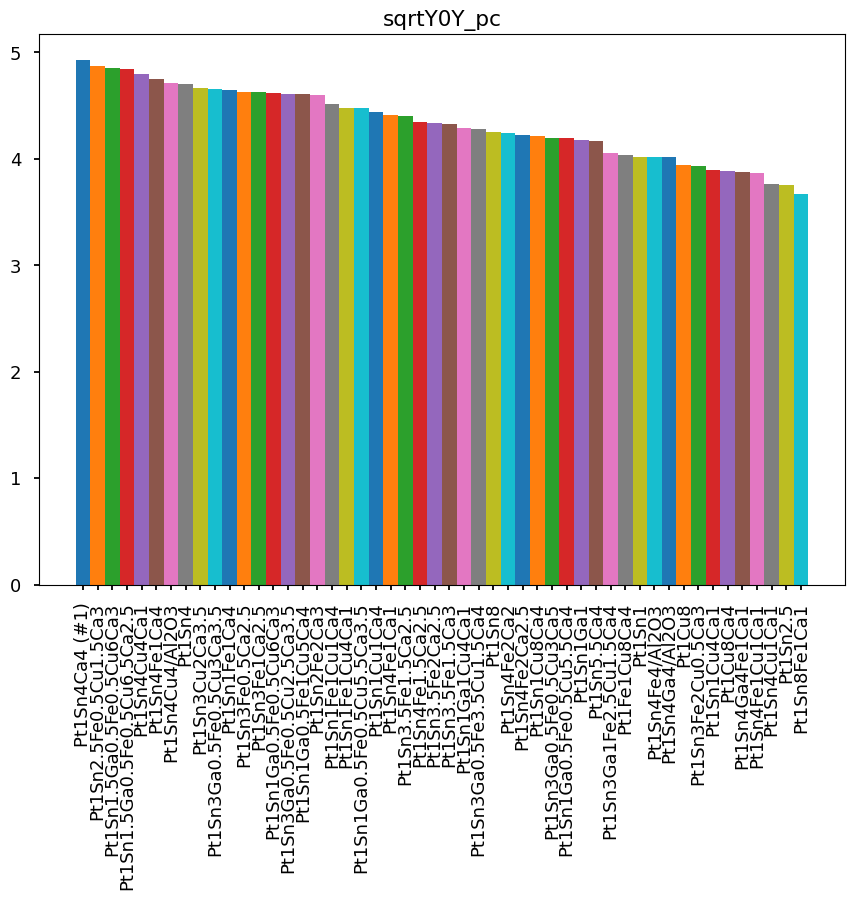

In [7]:
val = "sqrtY0Y_pc"
df2_sorted=df2.sort_values(by=val,ascending=False)

n=0
idx_list = []

for i in  range(df2_sorted.shape[0]):
    if idx_list == []:
        idx_list.append(i)
    else:
        if not is_duplicate(df2_sorted,i,idx_list):
            idx_list.append(i)

df_subset = df2_sorted.iloc[idx_list,:]
names = df_subset["Catalyst"]
scores = df_subset[val]

n = 50
width =1
color_list = ['r','g','b','c','m','y','k','darkorange','palegreen','fuchsia','olive']
fig, ax = plt.subplots()
for i in range(n):
    ax.bar(i,scores.iloc[i],width=width,label=names.iloc[i])
plt.xticks([i for i in range(n)],names.iloc[0:n],rotation=90)
plt.title(val)
#plt.legend(loc='upper left')
# plt.ylim((0,1.9))
plt.show()
#plt.savefig("./manuscript_figures/data-analysis-score.png",dpi=600,bbox_inches='tight')
#df2.to_csv(f'./manuscript_figures/all-data-no-duplicates-sorted-by-{val}.csv')

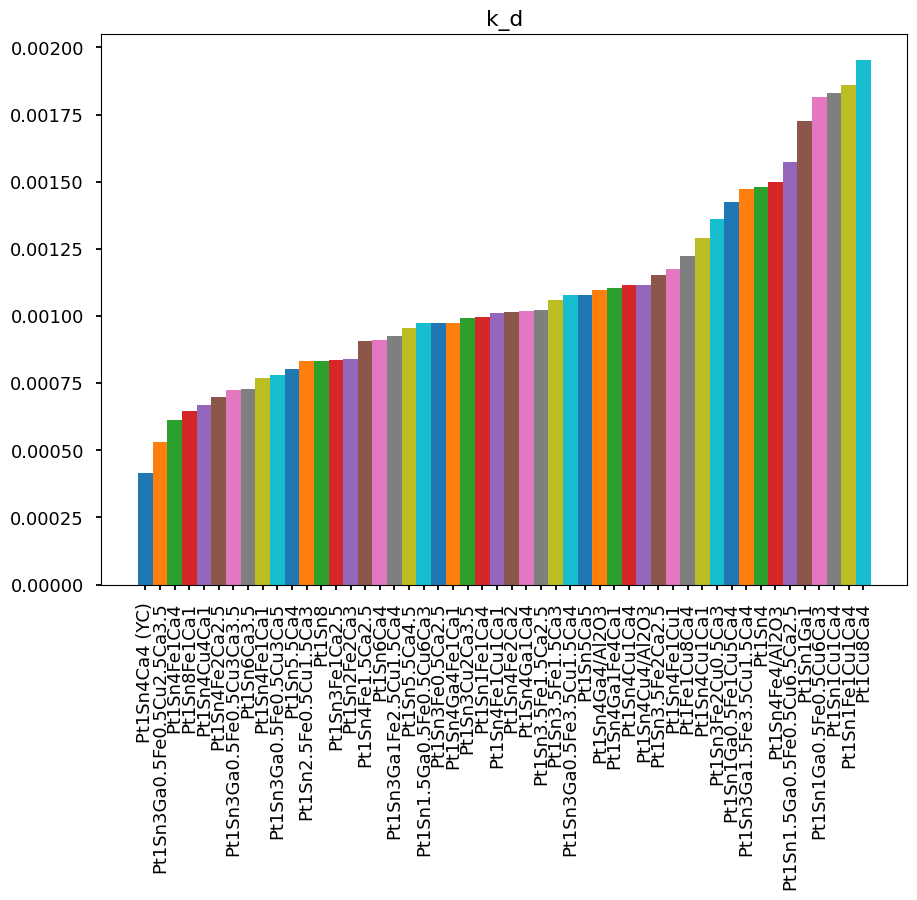

In [8]:
val = "k_d"
df2_sorted=df2.sort_values(by=val,ascending=True)

n=0
idx_list = []

for i in  range(df2_sorted.shape[0]):
    if idx_list == []:
        idx_list.append(i)
    else:
        if not is_duplicate(df2_sorted,i,idx_list):
            idx_list.append(i)

df_subset = df2_sorted.iloc[idx_list,:]
names = df_subset["Catalyst"]
scores = df_subset[val]

n = 50
width =1
color_list = ['r','g','b','c','m','y','k','darkorange','palegreen','fuchsia','olive']
fig, ax = plt.subplots()
for i in range(n):
    ax.bar(i,scores.iloc[i],width=width,label=names.iloc[i])
plt.xticks([i for i in range(n)],names.iloc[0:n],rotation=90)
plt.title(val)
#plt.legend(loc='upper left')
# plt.ylim((0,1.9))
plt.show()
#plt.savefig("./manuscript_figures/data-analysis-k_d.png",dpi=600,bbox_inches='tight')
#df2.to_csv(f'./manuscript_figures/all-data-no-duplicates-sorted-by-{val}.csv')

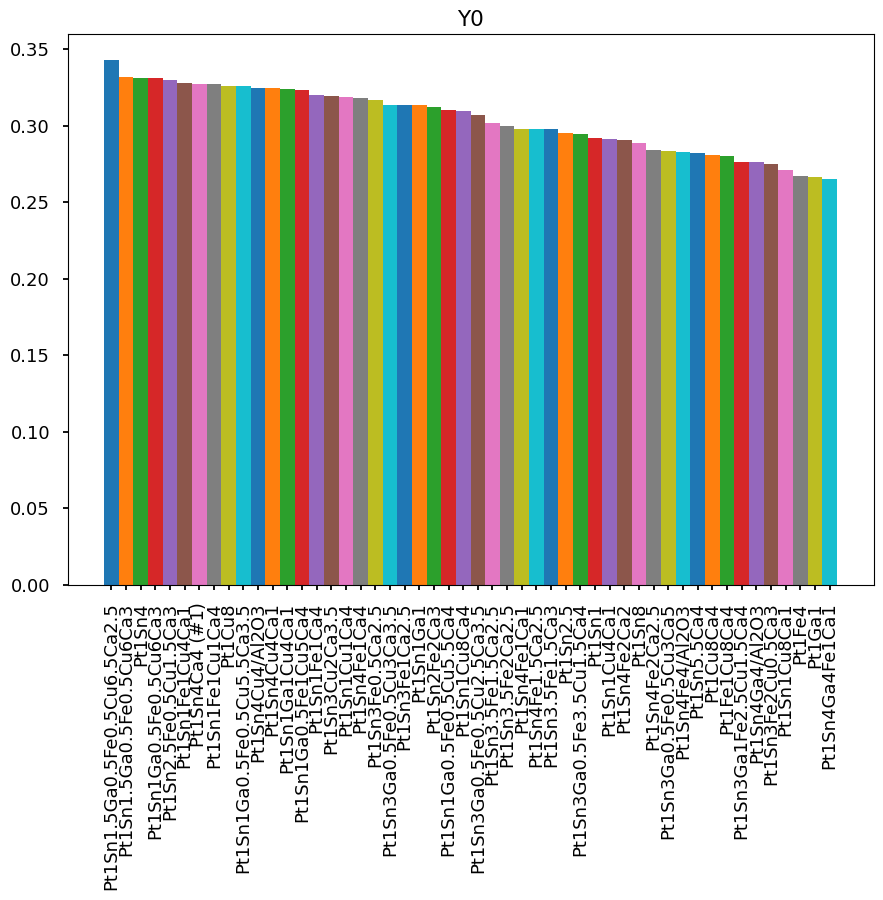

In [68]:
val = "Y0"
df2_sorted=df2.sort_values(by=val,ascending=False)

n=0
idx_list = []

for i in  range(df2_sorted.shape[0]):
    if idx_list == []:
        idx_list.append(i)
    else:
        if not is_duplicate(df2_sorted,i,idx_list):
            idx_list.append(i)

df_subset = df2_sorted.iloc[idx_list,:]
names = df_subset["Catalyst"]
scores = df_subset[val]

n = 50
width =1
color_list = ['r','g','b','c','m','y','k','darkorange','palegreen','fuchsia','olive']
fig, ax = plt.subplots()
for i in range(n):
    ax.bar(i,scores.iloc[i],width=width,label=names.iloc[i])
plt.xticks([i for i in range(n)],names.iloc[0:n],rotation=90)
plt.title(val)
#plt.legend(loc='upper left')
# plt.ylim((0,1.9))
#plt.savefig("./manuscript_figures/data-analysis-Y0.png",dpi=600,bbox_inches='tight')
plt.show()

In [28]:
df2_sorted.iloc[5,:]

Unnamed: 0                           86
Catalyst          Pt1Sn2.5Fe0.5Cu1.5Ca3
Reaction                         24-035
Tube                                  3
Date                         2024-05-26
Mass Catalyst                      20.2
Mass Diluent                      120.1
k_d                            0.000833
Y0                              0.33006
lifetime_yield               396.241877
Y_pc                          71.798589
sqrtY0Y_pc                     4.868041
Pt                                    1
Sn                                  2.5
Ga                                  0.0
Fe                                  0.5
Cu                                  1.5
Ca                                  3.0
Mn                                    0
Zn                                    0
Name: 72, dtype: object